# Regression Notebook with Census Data

The purpose of this notebook is to find explanatory variables that influence the volume of groundwater testing in California. More information on data and context can be found in the  (1) Background and (2) Data Notion pages to better understand the data being used.

## Specialty Imports
* Zipcode and SearchEngine will be utilized for a reverse geocoding function

In [1]:
# Set Up
import pandas as pd
import numpy as np

# GIS/Location Related"
#!pip install uszipcode
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)


# Graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,10)
import seaborn as sns

# Regression
import statsmodels.api as sm

## Reverse geocoder function
Credits: https://stackoverflow.com/questions/60324730/reverse-geo-coding-without-google-api-for-zip-codes


In [2]:
def coord_to_zip(lat,lng):
    """ 
    Reverse geocoder that takes a lat and longitude value and finds the zipcode
    """
    zip_code = []
    for x,y in zip(lat,lng):
        result = search.by_coordinates(lat=x, lng=y, radius=14, returns=5)
        zip_code.append(result[0].zipcode)
    return zip_code

# Loading Data
We will be using the cleaned data from Ro that has various ACS forms/Census forms compiled by zipcode. Learn more at the Data tab of the Notion page!
https://github.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/blob/master/
 
* _income_ measures wealth and taxes by zipcode
* _demo_ provides demographics by zipcode
* _econ_ measures employment by zipcode

For now, we're going to drop records with missing values.


In [3]:
income = pd.read_csv('../assorted_data/income_by_zip.csv')
income = income[['Zipcode','TotalWages']].rename({'Zipcode': 'Zip Code'}, axis = 1)

demo = pd.read_csv('../census_data/demo.txt', sep = '\t').dropna()
demo['Zip Code'] = demo['ZCTA5']

econ = pd.read_csv('../census_data/econ.txt', sep = '\t').dropna()
econ['Zip Code'] = demo['ZCTA5']

In [4]:
# The following hashed out code will reverse-geocode the GAMA data but
# due to the long run time.

# gama['Zip Code'] = coord_to_zip(gama['latitude'], gama['longitude'])
# gama.to_csv("gama_2019_geocoded.csv")


# Loads pre-geocoded GAMA data
gama = pd.read_csv('../gama_data/gama_2019_geocoded.csv').dropna(axis = 0)


# Cleaning and Wrangling

### Aggregating the number of tests and then counting 

In [13]:
gama_test_counts = pd.DataFrame(gama.groupby(['Zip Code'])['results'].agg('count')).reset_index().astype(int)
gama_test_counts

,Zip Code,results
0,91950,82
1,92058,82
2,92061,76
3,92071,74
4,92086,157
5,92591,81
6,92592,160
7,93242,83
8,93609,84
9,93619,76


### Merging the dataframes, then using more readable labels

In [25]:
gama_demo = pd.merge(left = gama_test_counts, right = demo, on = 'Zip Code')
g_d_econ  = pd.merge(left = gama_demo, right = econ, on = 'Zip Code')

final = g_d_econ.rename({'results': "Number of Tests",}, axis = 1)
final.shape

(18, 380)

# Checkpoint

It is not ideal that we could only find information for 18 zip codes. A naive single-variable OLS will likely suffer from large standard errors. Luckily, the aim of this project is to _explore_ possible features rather than conclusively determine features. In the future, I would want to spend more time cleaning and exploring the data. Ideas I have currently are:

1. Running PCA on the 379 features and then cross validating to measure my error. I haven't investigated all the features and it might be that the census data is inherently low rank. For example, there may be many linear combinations of income measures. 
2. Stepwise Regression, Backward Selection, or Forward Selection for feature selection

However let's see if the data we have, again which is by zipcode, describes a region. For example, what if all the zipcodes were in the South Bay? From that perspective, we actually have as rich of a granularity we could ask for!


Click Here to View in Your Browser
 ==> https://www.easymapmaker.com/map/0191e9e8c3e6855fe1e390003db8c360
 


![final_map](../images/final_map.png)

Nice! While a more rigorous data cleaning process could probability give us more results for more regions in California. This "EDA" of sorts provides the following insights

* We can filter the 'final' dataframe for Fresno-tangent locations such that we could use our results to explain the Fresno region.
* Future cleaning could allow us to create models and associative claims for regions within California


# A Simple Model for Fresno, California

Out of curiosity let's run a simple single-variable OLS and feature slection process for the sake of exploration. Zipcodes that are in Fresno and the 'final' dataframe begin with '93xxx'


In [26]:
fresno = final[final['Zip Code'] > 93000]

In [27]:
corr = fresno.corr()
corr_target = abs(corr["Number of Tests"])

#Selecting highly correlated features
relevant_features = corr_target[corr_target>0.5].index

# Running the OLS

In [28]:
Y = fresno[["Number of Tests"]]


X_train = fresno[['hispanic_or_latino_and_race_detailed-population-not_hispanic_or_latino_other_total_population']]

X_with_const = sm.add_constant(X_train)

linear_model = sm.OLS(Y, X_with_const).fit()
linear_model.summary()

/Users/winsontruong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Number of Tests   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     3.726
Date:                Thu, 02 Jul 2020   Prob (F-statistic):             0.0824
Time:                        21:02:13   Log-Likelihood:                -61.280
No. Observations:                  12   AIC:                             126.6
Df Residuals:                      10   BIC:                             127.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                            81.7300     15.093      5.415      0.000      48.101     115.359
hispanic_or_latino_and_race_detailed-population-not_hispanic_or_latino_other_total_population     0.4366      0.226      1.930      0.082      -0.067       0.941
==============================================================================
Omnibus:                        3.353   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                1.492
Skew:                           0.860   Prob(JB):                        0.474
Kurtosis:                       3.165   Cond. No.                         79.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression + Random Forest = Regression Forest

Thank you to William Koehrson for publishing a easy to follow guide on regression forest prediction! The following code has been adjusted from William's skeleton.

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [29]:
outcome = final['Number of Tests']
features = final.iloc[:,3:]
features.shape

(18, 377)

In [30]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                                            outcome, 
                                                                            test_size = 0.25, 
                                                                            random_state = 142)

In [31]:
from sklearn.ensemble import RandomForestRegressor

# 1000 Decision Trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 142)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=142, verbose=0, warm_start=False)

In [32]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
squared_errors = (predictions - test_labels) ** 2

# Print out the mean absolute error (mae)
print('RMSE:', np.sqrt(np.mean(squared_errors)))


RMSE: 36.16875317176416


In [33]:
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: income_and_benefits_in_2016_inflation_adjusted_dollars-percent-households_with_earnings-of-total_households Importance: 0.06
Variable: commuting_to_work-percent-worked_at_home-of-workers_16_years_and_over Importance: 0.05
Variable: race-population-one_race_american_indian_and_alaska_native_total_population Importance: 0.04
Variable: hispanic_or_latino_and_race_detailed-population-not_hispanic_or_latino_other_total_population Importance: 0.04
Variable: sex_and_age-percent-35_to_44_years-of-total_population Importance: 0.03
Variable: race-percent-one_race_american_indian_and_alaska_native-of-total_population Importance: 0.03
Variable: income_and_benefits_in_2016_inflation_adjusted_dollars-percent-150000_to_199999-of-total_households Importance: 0.03
Variable: income_and_benefits_in_2016_inflation_adjusted_dollars-dollars-mean_cash_public_assistance_income_dollars_households_with_cash_public_assistance_income Importance: 0.03
Variable: race-population-one_race_native_hawaiian_an

That's a bit messy so let's clean that up and visualize.

In [34]:
impt_features = pd.DataFrame(columns = ['Features', 'Importance'])

# Manually naming the features
impt_features['Features'] = ['Income per Household',
                            '% of Commuters relative to WFH',
                            'Number of American Indian and Alaskan Native',
                             'Number of Hispanic/Latino identifying',
                            'Percentage of 35-44 Year Olds',
                            '% of American Indian and Alaskan Natives',
                            'Income per Household 3',
                            'Income per Household w/ Public Assistance',
                            'Number of Native Hawaiians',
                            '% of Native Hawaiins',
                            'Other Pacific Islanders']

impt_features['Importance'] = [i[1] for i in feature_importances][0:11]

impt_features

,Features,Importance
0,Income per Household,0.06
1,% of Commuters relative to WFH,0.05
2,Number of American Indian and Alaskan Native,0.04
3,Number of Hispanic/Latino identifying,0.04
4,Percentage of 35-44 Year Olds,0.03
5,% of American Indian and Alaskan Natives,0.03
6,Income per Household 3,0.03
7,Income per Household w/ Public Assistance,0.03
8,Number of Native Hawaiians,0.02
9,% of Native Hawaiins,0.02


# Analysis
The table above tells us the Top 10 most important features in terms of predicting the number of tests per zipcode. While the names have been simplified and further work would be necessary to fully understand the American Community Survey metric (FIPS code) meaning, in general we have astounding evidence for our hypothesis. 

Of the top 10 most important features, we see _historically_ marginalized populations such as Native Americans, Alaskan Natives, and Native Hawaiian identifying populations being significant as well as those who are on some form of public assistance such as Medicare/Medicaid.

Text(0.5, 1.0, 'Top 10 Features in Determining the Number of Groundwater Tests per Zipcode from the Random Forest Model')

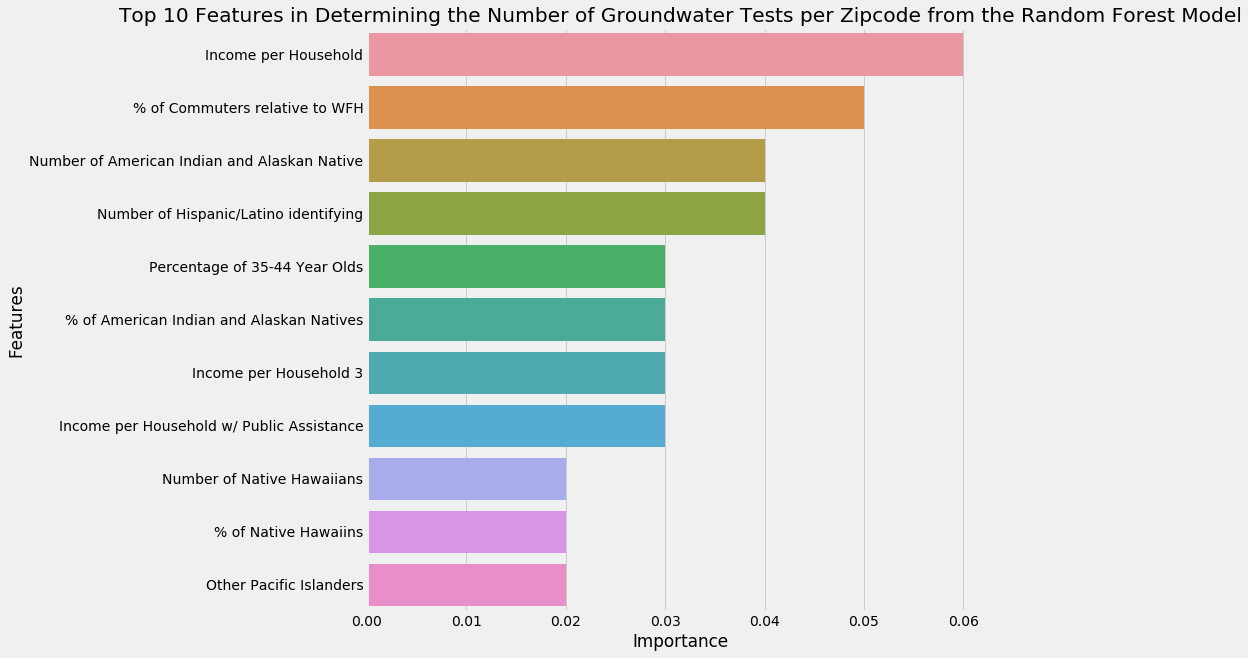

In [35]:
sns.barplot(y = 'Features', x = 'Importance', data = impt_features, orient = 'h')
plt.title('Top 10 Features in Determining the Number of Groundwater Tests per Zipcode from the Random Forest Model')

# References
* PCA and Small Sample Sizes https://stats.stackexchange.com/questions/116132/regression-with-very-small-sample-size

* Feature Selection https://towardsdatascience.com/feature-selection-techniques-in-regression-model-26878fe0e24e

